In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from dgl.dataloading import GraphDataLoader

from src.dataset import VarOptimalityDataset
from src.net import InstanceGCN

In [26]:
instances_fps = list(Path('../data/raw/').glob('97_9_*.json'))

ds = VarOptimalityDataset(instances_fps[:5], sols_dir='../data/interim/', samples_per_instance=10, return_model=False)

len(ds)

50

In [31]:
g, y = ds[0]
g, y

(Graph(num_nodes={'con': 5530, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 61390, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 61390},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 tensor([0, 0, 0,  ..., 1, 0, 1]))

In [32]:
net = InstanceGCN(n_var_feats=8, readout_op=None)

y_hat = net(g)

y_hat.shape

torch.Size([1, 1746])

In [34]:
y.shape

torch.Size([1746])

tensor([[0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804]],
       dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [27]:
dl = GraphDataLoader(ds, batch_size=5)

dl

In [28]:
g, y = next(iter(dl))
net(g)

tensor([[0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
        [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
        [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
        [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
        [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804]],
       dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [42]:
import numpy as np

from src.dataset import MultiTargetDataset
from src.net import InstanceGCN, VarInstanceGCN
from src.utils import load_from_wandb


instances_dir = Path('/home/bruno/sat-gnn/data/raw')
instances_fpaths = list(instances_dir.glob('97_9*.json'))

ds = MultiTargetDataset(instances_fpaths, split='val', return_model=True)

# net = InstanceGCN(readout_op=None)
net = VarInstanceGCN(readout_op=None)
net = load_from_wandb(net, '7cldzalb', 'sat-gnn', 'model_last')
net.eval()

ps = list()
for graph, _, model in ds:
    vars_names = np.core.defchararray.array([v.name for v in model.getVars()])
    # vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    with torch.no_grad():
        x_hat = net.get_candidate(graph)

    p_hat = 2 * (x_hat - 0.5).abs()
    ps.append(p_hat)
ps = torch.stack(ps)

In [48]:
ps.shape

torch.Size([20, 1746])

In [52]:
vars_names = np.core.defchararray.array([v.name for v in model.getVars()])
# vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]
vars_names

chararray(['x(0,0)', 'x(0,1)', 'x(0,2)', ..., 'phi(8,94)', 'phi(8,95)',
           'phi(8,96)'], dtype='<U9')

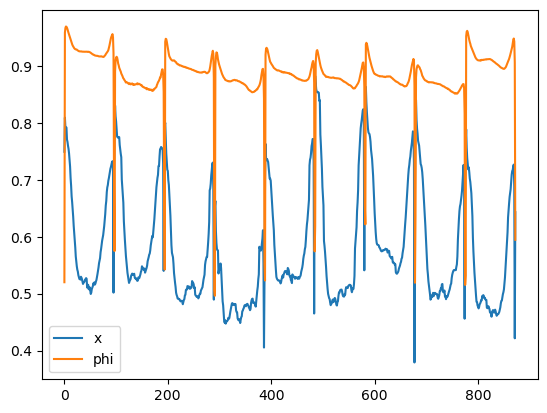

In [54]:
plt.plot(ps.mean(0)[vars_names.find('x(') >= 0], label='x')
plt.plot(ps.mean(0)[vars_names.find('phi(') >= 0], label='phi')
plt.legend()
plt.show()